In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler, LabelEncoder

c:\Users\Acer\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
# 1. Load the CSV
df = pd.read_csv("../Data/alzheimer_healthy_aging.csv.csv")

# 2. Separate your target (Class) from your features
# Replace 'Class' with the actual name of your target column if it's different
X_tabular = df.drop('Class', axis=1) 
y_tabular = df['Class']

# 3. MAGIC STEP: Convert all text columns to numbers automatically
# This creates "dummy" columns (0s and 1s) for any text it finds
X_tabular_numeric = pd.get_dummies(X_tabular)

# 4. Now that everything is a number, we can scale it
scaler = StandardScaler()
X_tabular_scaled = scaler.fit_transform(X_tabular_numeric)

print("Success! Tabular data shape is now:", X_tabular_scaled.shape)
print("The text columns have been converted to numbers.")

C:\Users\Acer\AppData\Local\Temp\ipykernel_19460\242100928.py:2: DtypeWarning: Columns (13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../Data/alzheimer_healthy_aging.csv.csv")
c:\Users\Acer\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\Acer\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\Acer\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Success! Tabular data shape is now: (214462, 4309)
The text columns have been converted to numbers.


In [3]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# For Fusion, we often need the data as Numpy arrays rather than Generators
# To keep it simple for a beginner, ensure your batch_size matches your data size
train_images, train_labels = next(datagen.flow_from_directory(
    "../Data/Alzheimerr/train_set/", target_size=(128, 128), batch_size=1000))

Found 7200 images belonging to 4 classes.


In [4]:
# BRANCH 1: The Image Branch (CNN)
image_input = Input(shape=(128, 128, 3), name="image_input")
x = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
image_branch = layers.Dense(64, activation='relu')(x)

# BRANCH 2: The Tabular Branch (ANN)
tabular_input = Input(shape=(X_tabular_scaled.shape[1],), name="tabular_input")
y = layers.Dense(32, activation='relu')(tabular_input)
tabular_branch = layers.Dense(16, activation='relu')(y)

# THE FUSION: Combine the two branches
combined = layers.concatenate([image_branch, tabular_branch])

# Final layers for prediction
z = layers.Dense(32, activation='relu')(combined)
output = layers.Dense(4, activation='softmax')(z)

# Create the final model
fusion_model = Model(inputs=[image_input, tabular_input], outputs=output)
fusion_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

fusion_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tabular_input       │ (None, 4309)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 127008)    │          0 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │    137,920 │ tabular_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │  8,128,576 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │        528 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 80)        │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      2,592 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 4)         │        132 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,270,644 (31.55 MB)

 Trainable params: 8,270,644 (31.55 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Note: You would normally use a proper train/test split here
# This is a simplified example of how to feed two inputs
history = fusion_model.fit(
    x=[train_images, X_tabular_scaled[:1000]], # Feeding both images and CSV data
    y=train_labels,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 344ms/step - accuracy: 0.2525 - loss: 2.0270 - val_accuracy: 0.3550 - val_loss: 1.4322
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 330ms/step - accuracy: 0.3575 - loss: 1.3079 - val_accuracy: 0.3300 - val_loss: 1.2712
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 332ms/step - accuracy: 0.4725 - loss: 1.1861 - val_accuracy: 0.5300 - val_loss: 1.1865
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 341ms/step - accuracy: 0.6737 - loss: 0.9685 - val_accuracy: 0.5000 - val_loss: 1.1575
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 314ms/step - accuracy: 0.6963 - loss: 0.7732 - val_accuracy: 0.4750 - val_loss: 1.1914
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 316ms/step - accuracy: 0.8288 - loss: 0.5844 - val_accuracy: 0.5050 - val_loss: 1.2348
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 325ms/step - accuracy: 0.9175 - loss: 0.3698 - val_accuracy: 0.5650 - val_loss: 1.1008
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 325ms/step - accuracy: 0.9650 - loss: 0.2286 - val_accuracy:

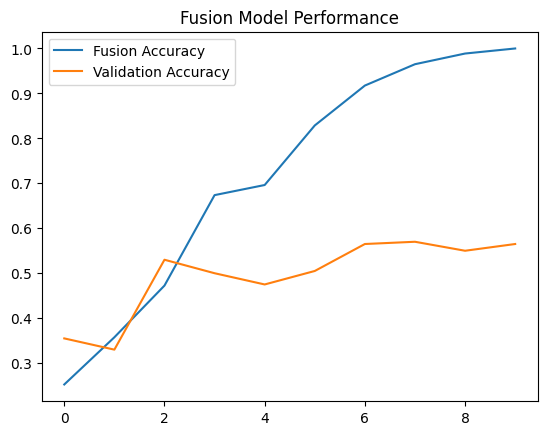

<Figure size 640x480 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Fusion Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Fusion Model Performance')
plt.legend()
plt.show()
plt.savefig('../Outputs/fusion_plot.png')

In [7]:
# Save the final Fusion model
fusion_model.save('../Outputs/final_fusion_model.h5')

# Create a final CSV for Power BI
y_pred = fusion_model.predict([train_images, X_tabular_scaled[:1000]])
results_df = pd.DataFrame({
    'Actual': np.argmax(train_labels, axis=1),
    'Predicted': np.argmax(y_pred, axis=1)
})
results_df.to_csv('../Outputs/power_bi_results.csv', index=False)

print("Fusion Model and Power BI CSV saved to Outputs folder!")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Fusion Model and Power BI CSV saved to Outputs folder!
